# Lyft: Prediction with multi-mode confidence

![](http://www.l5kit.org/_images/av.jpg)
<cite>The image from L5Kit official document: <a href="http://www.l5kit.org/README.html">http://www.l5kit.org/README.html</a></cite>

Continued from the previous kernel:
 - [Lyft: Comprehensive guide to start competition](https://www.kaggle.com/corochann/lyft-comprehensive-guide-to-start-competition)
 - [Lyft: Deep into the l5kit library](https://www.kaggle.com/corochann/lyft-deep-into-the-l5kit-library)
 - [Lyft: Training with multi-mode confidence](https://www.kaggle.com/corochann/lyft-training-with-multi-mode-confidence)

In this kernel, I will run **prediction code for competition submission** where the model is trained in previous kernel.

<span style="color:red">I uploaded trained models as dataset <a href="https://www.kaggle.com/corochann/lyft-resnet18-baseline">lyft-resnet18-baseline</a><br/>
Please <b>upvote the dataset</b> as well if this kernel helps you :)</span>

# Environment setup

 - Please add [pestipeti/lyft-l5kit-unofficial-fix](https://www.kaggle.com/pestipeti/lyft-l5kit-unofficial-fix) as utility script.
    - Official utility script "[philculliton/kaggle-l5kit](https://www.kaggle.com/mathurinache/kaggle-l5kit)" does not work with pytorch GPU.
 - Please add dataset:
    - [lyft-config-files](https://www.kaggle.com/jpbremer/lyft-config-files)
    - [lyft-resnet18-baseline](https://www.kaggle.com/corochann/lyft-resnet18-baseline)
 
See previous kernel [Lyft: Comprehensive guide to start competition](https://www.kaggle.com/corochann/lyft-comprehensive-guide-to-start-competition) for details.

In [26]:
# !pip install pytorch-pfn-extras==0.6.1

  Using cached pytorch_pfn_extras-0.6.1-py3-none-any.whl
  Attempting uninstall: pytorch-pfn-extras
    Found existing installation: pytorch-pfn-extras 0.3.1
    Uninstalling pytorch-pfn-extras-0.3.1:
      Successfully uninstalled pytorch-pfn-extras-0.3.1


In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
# pd.set_option('max_columns', 50)

/tmp/ipykernel_262801/525924121.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import zarr

import l5kit
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable
from l5kit.evaluation import write_pred_csv

from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
print("l5kit version:", l5kit.__version__)

l5kit version: 1.5.0


In [4]:
import torch
from pathlib import Path

# import pytorch_pfn_extras as ppe
# from math import ceil
# from pytorch_pfn_extras.training import IgniteExtensionsManager
# from pytorch_pfn_extras.training.triggers import MinValueTrigger

from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
# import pytorch_pfn_extras.training.extensions as E

## Model

pytorch model definition. Here model outputs both **multi-mode trajectory prediction & confidence of each trajectory**.

In [5]:
# --- Model utils ---
import torch
from torchvision.models import resnet18
from torch import nn
from typing import Dict


class LyftMultiModel(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        # TODO: support other than resnet18?
        backbone = resnet18(pretrained=True, progress=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        # This is 512 for resnet18 and resnet34;
        # And it is 2048 for the other resnets
        backbone_out_features = 512

        # X, Y coords for the future positions (output shape: Bx50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_features=backbone_out_features, out_features=4096),
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.head(x)
        x = self.logit(x)

        # pred (bs)x(modes)x(time)x(2D coords)
        # confidences (bs)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

    

In [6]:
# --- Utils ---
import yaml


def save_yaml(filepath, content, width=120):
    with open(filepath, 'w') as f:
        yaml.dump(content, f, width=width)


def load_yaml(filepath):
    with open(filepath, 'r') as f:
        content = yaml.safe_load(f)
    return content


class DotDict(dict):
    """dot.notation access to dictionary attributes

    Refer: https://stackoverflow.com/questions/2352181/how-to-use-a-dot-to-access-members-of-dictionary/23689767#23689767
    """  # NOQA

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__



In [7]:
def visualize_trajectory(dataset, index, title="target_positions movement with draw_trajectory"):
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)

    im = dataset.rasterizer.to_rgb(im)

    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    # print(target_positions_pixels)
    draw_trajectory(im, target_positions_pixels, yaws=data["target_yaws"], rgb_color=TARGET_POINTS_COLOR)
    # draw_trajectory(im, target_positions_pixels, yaws=data["target_yaws"], rgb_color=PREDICTED_POINTS_COLOR)
    # 这个yaw只会影响一点点.拖拽是历史信息

    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()


In [8]:
from IPython.display import display, clear_output
import PIL

def animation_self(dataset,scene_idx):
    indexes = dataset.get_scene_indices(scene_idx)
    images = []

    for idx in indexes:
        data = dataset[idx]

        im = data["image"].transpose(1, 2, 0)
        im = dataset.rasterizer.to_rgb(im)
        target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
        center_in_pixels = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
        draw_trajectory(im, target_positions_pixels, yaws =  data["target_yaws"], rgb_color=TARGET_POINTS_COLOR)
        clear_output(wait=True)
        images.append(PIL.Image.fromarray(im[::-1]))
    return images

In [9]:
%%capture
def animate_solution(images):

    def animate(i):
        im.set_data(images[i])
        return (im,)

    fig, ax = plt.subplots()
    im = ax.imshow(images[0])
    def init():
        im.set_data(images[0])
        return (im,)

    return animation.FuncAnimation(fig, animate, init_func=init, frames=len(images), interval=60, blit=True)

In [10]:
# Referred https://www.kaggle.com/pestipeti/pytorch-baseline-inference
def run_prediction(predictor, data_loader):
    predictor.eval()

    pred_coords_list = []
    confidences_list = []
    timestamps_list = []
    track_id_list = []
    i=0

    with torch.no_grad():
        dataiter = tqdm(data_loader)
        for data in dataiter:
            plt.xlim(-50,50)
            plt.ylim(-50,50)
            # print(data["target_positions"].numpy().copy())
            image = data["image"].to(device)
            true_coord = data["history_positions"].numpy().copy()
            coorx = true_coord[:,:,0]
            coory = true_coord[:,:,1]
            plt.scatter(coorx, coory)
            plt.plot(coorx, coory)
            # targets = data["target_positions"].to(device)
            pred, confidences = predictor(image)

            pred_coord = pred.cpu().numpy().copy()
            confidence = confidences.cpu().numpy().copy()
            pred_coords_list.append(pred_coord)
            confidences_list.append(confidence)
            timestamps_list.append(data["timestamp"].numpy().copy())
            track_id_list.append(data["track_id"].numpy().copy())
            
            MAX = 0
            maxj = -1
            for j in range(3):
                if confidence[0][j] > MAX:
                    MAX = confidence[0][j]
                    maxj = j
            
            coorx = pred_coord[:, maxj, :, 0]
            coory = pred_coord[:, maxj, :, 1]
            plt.scatter(coorx, coory)
            plt.plot(coorx, coory)
            plt.show()
            
    timestamps = np.concatenate(timestamps_list)
    track_ids = np.concatenate(track_id_list)
    coords = np.concatenate(pred_coords_list)
    confs = np.concatenate(confidences_list)
    
    return timestamps, track_ids, coords, confs


## Configs

In [11]:
# --- Lyft configs ---

cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': 'resnet50',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'render_ego_history':True,
        'step_time':0.1
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5,

        'set_origin_to_bottom': True,
        'disable_traffic_light_faces':False
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 12,
        'shuffle': True,
        'num_workers': 4
    },

    'valid_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 4
    },

    'test_data_loader': {
         'key': 'scenes/test.zarr',
         'batch_size': 8,
         'shuffle': False,
         'num_workers': 4
    },

    'train_params': {
        'max_num_steps': 10000,
        'checkpoint_every_n_steps': 5000,

        # 'eval_every_n_steps': -1
    }
}


In [12]:
flags_dict = {
    "debug": False,
    # --- Data configs ---
    "l5kit_data_folder": "/home/zhuhe/kaggle/input/lyft-motion-prediction-autonomous-vehicles",
    # --- Model configs ---
    "pred_mode": "multi",
    # --- Training configs ---
    "device": "cuda:0",
    "out_dir": "results/multi_train",
    "epoch": 2,
    "snapshot_freq": 50,
}

# Main script

Now finished defining all the util codes. Let's start writing main script to train the model!

## Loading data

Here we will only use the first dataset from the sample set. (sample.zarr data is used for visualization, please use train.zarr / validate.zarr / test.zarr for actual model training/validation/prediction.)<br/>
We're building a `LocalDataManager` object. This will resolve relative paths from the config using the `L5KIT_DATA_FOLDER` env variable we have just set.

In [13]:
flags = DotDict(flags_dict)
out_dir = Path(flags.out_dir)
os.makedirs(str(out_dir), exist_ok=True)
print(f"flags: {flags_dict}")
save_yaml(out_dir / 'flags.yaml', flags_dict)
save_yaml(out_dir / 'cfg.yaml', cfg)
debug = flags.debug

flags: {'debug': False, 'l5kit_data_folder': '/home/zhuhe/kaggle/input/lyft-motion-prediction-autonomous-vehicles', 'pred_mode': 'multi', 'device': 'cuda:0', 'out_dir': 'results/multi_train', 'epoch': 2, 'snapshot_freq': 50}


In [ ]:
# set env variable for data
l5kit_data_folder = "/home/zhuhe/kaggle/input/lyft-motion-prediction-autonomous-vehicles"
os.environ["L5KIT_DATA_FOLDER"] = l5kit_data_folder
dm = LocalDataManager(None)

print("Load dataset...")
default_test_cfg = {
    'key': 'scenes/test.zarr',
    'batch_size': 32,
    'shuffle': False,
    'num_workers': 4
}
test_cfg = cfg.get("test_data_loader", default_test_cfg)

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

test_path = test_cfg["key"]
print(f"Loading from {test_path}")
test_zarr = ChunkedDataset(dm.require(test_path)).open()
print("test_zarr", type(test_zarr))
test_mask = np.load(f"{l5kit_data_folder}/scenes/mask.npz")["arr_0"]
test_agent_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)
test_dataset = test_agent_dataset
if debug:
    # Only use 100 dataset for fast check...
    test_dataset = Subset(test_dataset, np.arange(100))
test_loader = DataLoader(
    test_dataset,
    shuffle=test_cfg["shuffle"],
    batch_size=test_cfg["batch_size"],
    num_workers=test_cfg["num_workers"],
    pin_memory=True,
)

print(test_agent_dataset)
print("# AgentDataset test:", len(test_agent_dataset))
print("# ActualDataset test:", len(test_dataset))

Load dataset...
Loading from scenes/test.zarr
test_zarr <class 'l5kit.data.zarr_dataset.ChunkedDataset'>


/tmp/ipykernel_262801/1877409036.py:23: RuntimeWarning:

you're running with a custom agents_mask



## Prepare model & optimizer

In [ ]:
device = torch.device(flags.device)
if flags.pred_mode == "multi":
    predictor = LyftMultiModel(cfg)
else:
    raise ValueError(f"[ERROR] Unexpected value flags.pred_mode={flags.pred_mode}")

pt_path = "/home/zhuhe/FALL/dev/brd_branch/predictor_full.pt"
print(f"Loading from {pt_path}")
predictor.load_state_dict(torch.load(pt_path))
predictor.to(device)

# Inference!

  0%|          | 0/8891 [00:00<?, ?it/s]

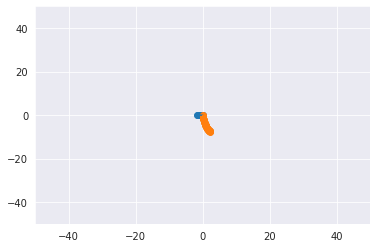

  0%|          | 1/8891 [00:00<2:07:50,  1.16it/s]

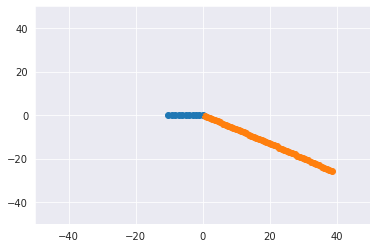

  0%|          | 2/8891 [00:01<1:06:49,  2.22it/s]

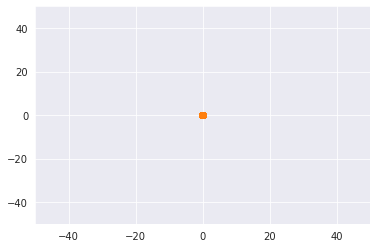

  0%|          | 3/8891 [00:01<46:42,  3.17it/s]  

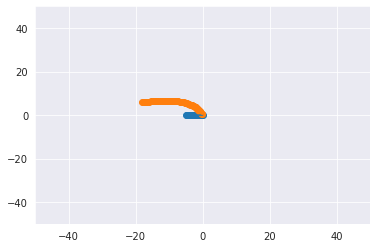

  0%|          | 4/8891 [00:01<35:54,  4.13it/s]

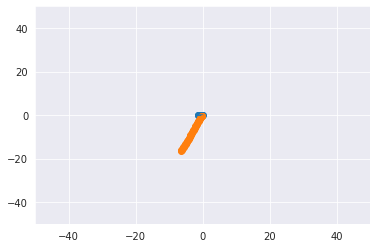

  0%|          | 5/8891 [00:01<30:02,  4.93it/s]

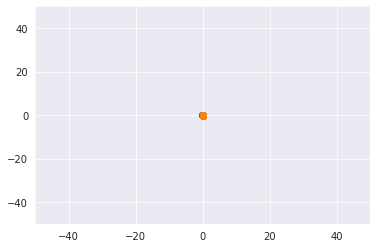

  0%|          | 6/8891 [00:01<28:02,  5.28it/s]

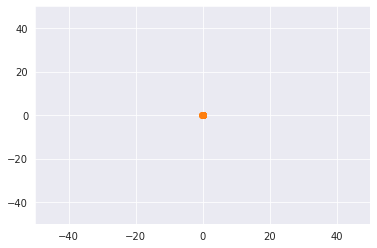

  0%|          | 7/8891 [00:01<26:00,  5.69it/s]

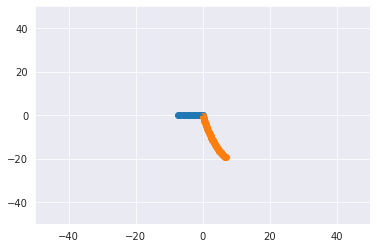

  0%|          | 8/8891 [00:01<25:06,  5.90it/s]

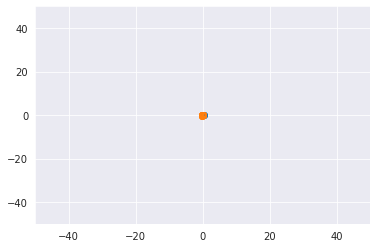

  0%|          | 9/8891 [00:02<24:35,  6.02it/s]

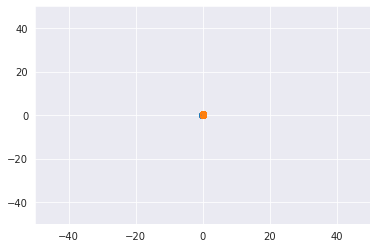

  0%|          | 10/8891 [00:02<24:30,  6.04it/s]

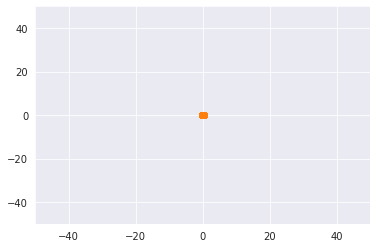

  0%|          | 11/8891 [00:02<23:01,  6.43it/s]

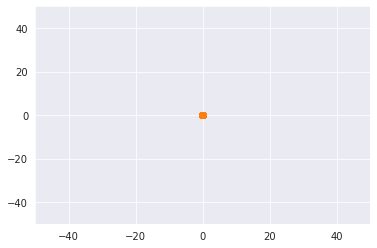

  0%|          | 12/8891 [00:02<23:56,  6.18it/s]

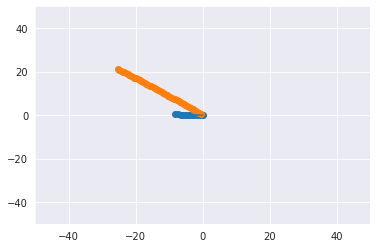

  0%|          | 13/8891 [00:02<22:53,  6.47it/s]

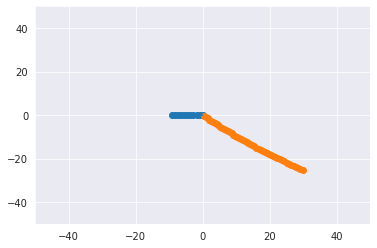

  0%|          | 14/8891 [00:02<30:45,  4.81it/s]


KeyboardInterrupt: 

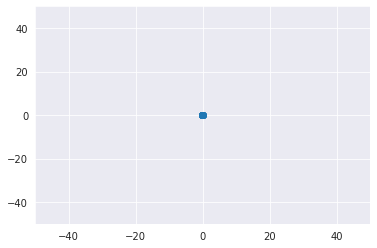

In [41]:
# --- Inference ---
timestamps, track_ids, coords, confs = run_prediction(predictor, test_loader)

In [4]:
csv_path = "submission.csv"
write_pred_csv(
    csv_path,
    timestamps=timestamps,
    track_ids=track_ids,
    coords=coords,
    confs=confs)
print(f"Saved to {csv_path}")

NameError: name 'write_pred_csv' is not defined

# Next to go

To understand the competition in more detail, please refer my other kernels too.
 - [Lyft: Comprehensive guide to start competition](https://www.kaggle.com/corochann/lyft-comprehensive-guide-to-start-competition)
 - [Lyft: Deep into the l5kit library](https://www.kaggle.com/corochann/lyft-deep-into-the-l5kit-library)
 - [Save your time, submit without kernel inference](https://www.kaggle.com/corochann/save-your-time-submit-without-kernel-inference)
 - [Lyft: pytorch implementation of evaluation metric](https://www.kaggle.com/corochann/lyft-pytorch-implementation-of-evaluation-metric)
 - [Lyft: Training with multi-mode confidence](https://www.kaggle.com/corochann/lyft-training-with-multi-mode-confidence)

Discussions:
 - [Is this the way how the autonomous car predicts motions?](https://www.kaggle.com/c/lyft-motion-prediction-autonomous-vehicles/discussion/179236)
 - [How to ensemble multi-trajectory predictions?](https://www.kaggle.com/c/lyft-motion-prediction-autonomous-vehicles/discussion/180931)

# Further reference

 - Paper of this Lyft Level 5 prediction dataset: [One Thousand and One Hours: Self-driving Motion Prediction Dataset](https://arxiv.org/abs/2006.14480)
 - [jpbremer/lyft-scene-visualisations](https://www.kaggle.com/jpbremer/lyft-scene-visualisations)

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>